In [338]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [339]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
from pprint import pprint
import pylab

In [340]:
%matplotlib inline

In [341]:
TEXT_COLOUR = {
    'PURPLE':'\033[95m',
    'CYAN':'\033[96m',
    'DARKCYAN':'\033[36m',
    'BLUE':'\033[94m',
    'GREEN':'\033[92m',
    'YELLOW':'\033[93m',
    'RED':'\033[91m',
    'BOLD':'\033[1m',
    'UNDERLINE':'\033[4m',
    'END':'\033[0m'
}

def print_bold(*msgs):
    print(TEXT_COLOUR['BOLD'])
    print(*msgs)
    print(TEXT_COLOUR['END'])

def print_green(*msgs):
    print(TEXT_COLOUR['GREEN'])
    print(*msgs)
    print(TEXT_COLOUR['END'])

def print_error(*msgs):
    print(TEXT_COLOUR['RED'])
    print(*msgs)
    print(TEXT_COLOUR['END'])

def wrap_green(msg):
    return TEXT_COLOUR['GREEN'] + msg + TEXT_COLOUR['END']

def wrap_red(msg):
    return TEXT_COLOUR['RED'] + msg + TEXT_COLOUR['END']

def up_down_str(val):
    msg = str(val)
    if val > 0:
        msg = wrap_green(msg)
    elif val < 0:
        msg = wrap_red(msg)
    return msg

In [342]:
exps = ['bert-base', 'bert-large', 'roberta-base', 'roberta-large', 'xlnet-base', 'xlnet-large']
tasks = ["CoLA","SST-2","MRPC","STS-B","QQP","MNLI", "MNLI-MM", "QNLI","RTE"]
tasks = ["CoLA","SST-2","MRPC","STS-B"]

metrics = {
    "CoLA":["mcc"],
    "MNLI":["acc"],
    "MNLI-MM":["acc"],
    "MRPC":["f1"],
    "QNLI":["acc"],
    "QQP":["f1"],
    "RTE":["acc"],
    "SST-2":["acc"],
    "STS-B":["spearmanr"],
    "WNLI":["acc"] #temp
}

def get_average_val(lines):
    reported = []
    for line in lines:
        val = float(line.split('\t')[1])
        if val != 0:
            reported.append(val)
    out = 0
    if len(reported) != 0:
        reported.sort(reverse = True)
        candidates = [reported[0]]
        for j in range(1, len(reported)):
            if reported[j] > 0.9 * reported[0]:
                candidates.append(reported[j])
        out = np.mean(candidates)
        
    return out

In [343]:
result_folder = "temp_graph"
name_mapping = {
    "bert":"BERT",
    "roberta":"roBERTa",
    "xlnet":"XLNet"
}

results = {}

for task in tasks:
    results[task] = {}
    task_metrics = metrics[task]
    for metric in task_metrics:
        task_results = {
            'base':{
                'all':[]
            },
            'large':{
                'all':[]
            }
        }
        
        for exp in exps:

            # base metrics
            f=open(f"../{result_folder}/{exp}/{task}/base-{metric}.txt", "r")
            lines = f.read().splitlines()
            
            if "base" in exp:
                task_results['base']['all'].append(get_average_val(lines))
            elif "large" in exp:
                task_results['large']['all'].append(get_average_val(lines))

            # no layer metrics

            fine_tuning_metrics = []
            f=open(f"../{result_folder}/{exp}/{task}/no_layer-{metric}.txt", "r")

            lines = f.read().splitlines()
            fine_tuning_metrics.append(get_average_val(lines))

            # fine-tuned metrics

            if "base" in exp:
                num_layers = 12
            elif "large" in exp:
                num_layers = 24
            
            log_file_prefix=''
            for i in reversed(range(int(num_layers/2), num_layers)):
                log_file_prefix += str(i)
                f=open(f"../{result_folder}/{exp}/{task}/{log_file_prefix}-{metric}.txt", "r")
                lines = f.read().splitlines()
                fine_tuning_metrics.append(get_average_val(lines))

                log_file_prefix +='_'

#             task_results[exp] = list(reversed(fine_tuning_metrics))

            model_name = name_mapping[exp.split('-')[0]]
            
            if "base" in exp:
                task_results['base'][model_name] = list(reversed(fine_tuning_metrics))
            elif "large" in exp:
                task_results['large'][model_name] = list(reversed(fine_tuning_metrics))
                
        results[task][metric] = task_results


In [344]:
color_mapping = {
    "bert":'green',
    "roberta":'red',
    "xlnet":'blue',
    "BERT":'green',
    "roBERTa":'red',
    "XLNet":'blue'
}

y_label_mapping = {
    "mcc":'MCC',
    "f1":'F1',
    "acc":'Accuracy',
    "spearmanr":'Spearman'
}

models = ["BERT", "roBERTa", "XLNet"]

legends = None

def draw_graph(exp, task, y_label, collected):
    fig = plt.figure(figsize=(10,6))
    
    # x axis
    x_axis = []
    
    if "base" in exp:
        num_layers = 12
    elif "large" in exp:
        num_layers = 24

    for i in range(int(num_layers/2), num_layers):
        x_axis.append(str(i))
#     x_axis.append(f"{num_layers} (all)")
    x_axis.append("all")
                
    legends = []
    
    # baseline
    for ind, model in enumerate(models):
        handle = plt.axhline(y=collected['all'][ind], linestyle='--', label=model, c=color_mapping[model])
        legends.append(handle)
        
        handle = plt.plot(x_axis, collected[model], linestyle='-', label=model, c=color_mapping[model])
        legends.append(handle)
        
    # y-lim
    if y_label == "f1" or y_label == "acc"or y_label == "spearmanr":
#         plt.ylim(0, 1)
        plt.ylim(0.5, 1)
    elif y_label == "mcc":
#         plt.ylim(-1, 1)
        plt.ylim(0, 0.8)
        
    plt.rcParams.update({'font.size': 15})

    # legend
    plt.legend(legends,     # The line objects
       labels=["BERT-unfrozen", "BERT-frozen", "roBERTa-unfrozen", "roBERTa-frozen", "XLNet-unfrozen", "XLNet-frozen"], 
       loc=8,  # Position of legend
       ncol=3,
       bbox_to_anchor=(0.5, -0.35)
       )
    
    
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    
    plt.xlabel("Number of frozen layers", fontsize=20)
    plt.ylabel(y_label_mapping[y_label], fontsize=20)
    
    plt.title(f'{task}-{exp}', fontsize=23)
    plt.savefig(f'images/combined/{task}-{exp}.png', format='png', bbox_inches='tight')
    plt.show()

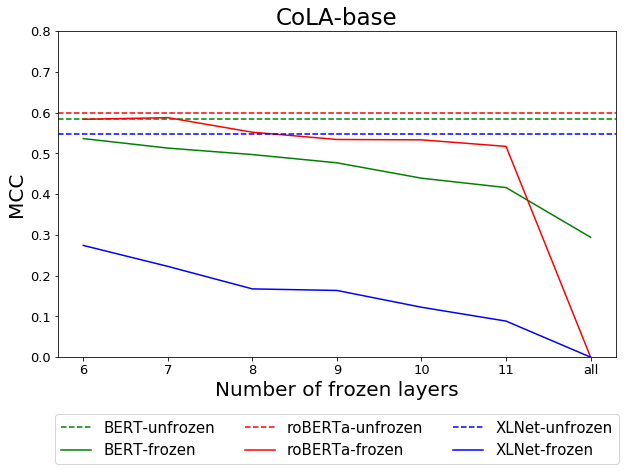

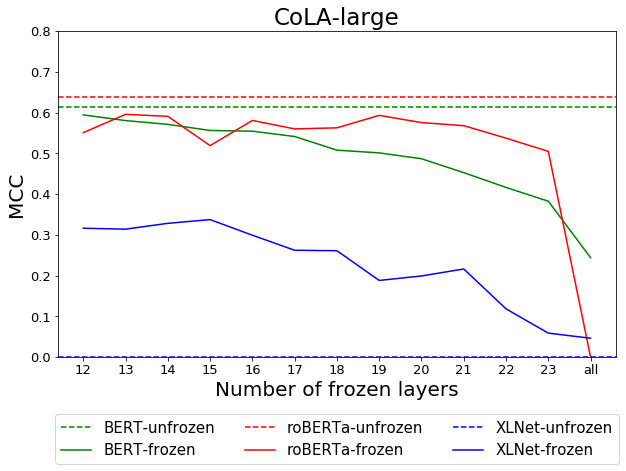

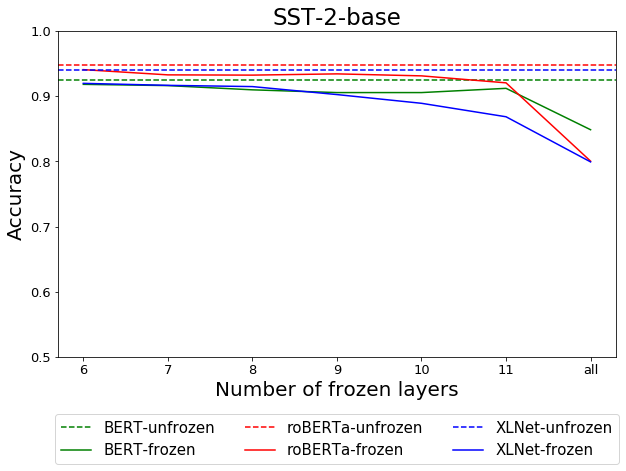

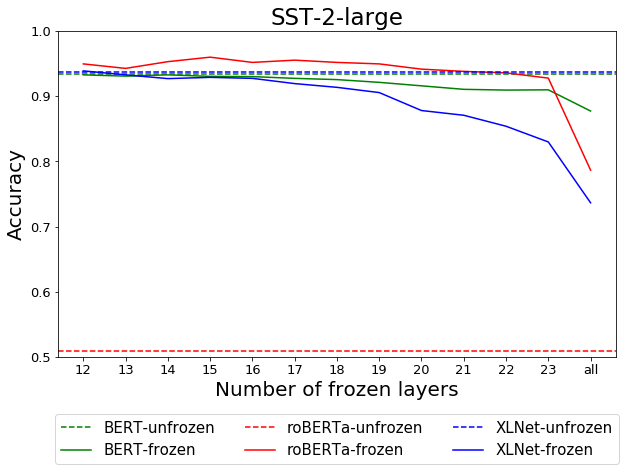

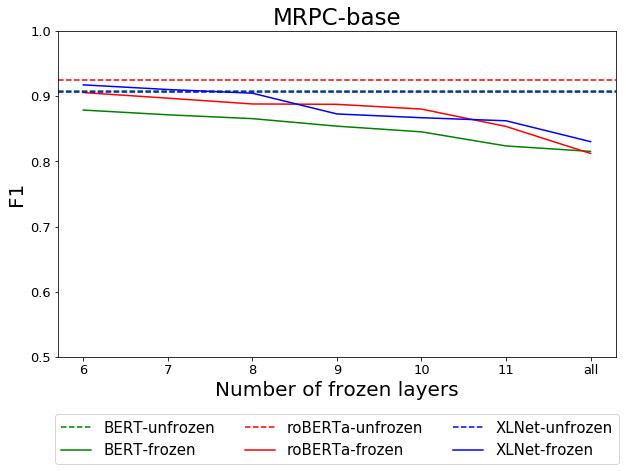

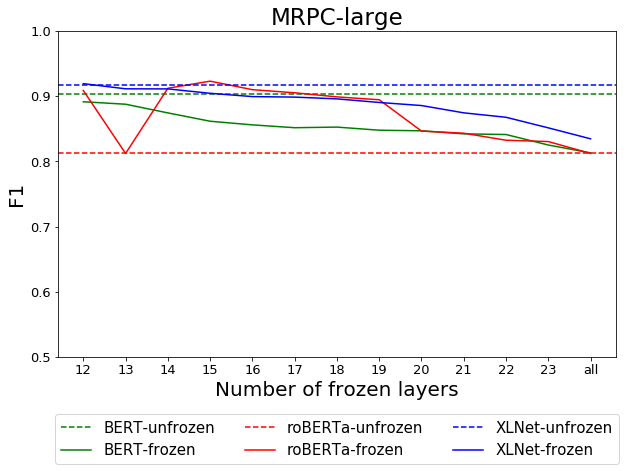

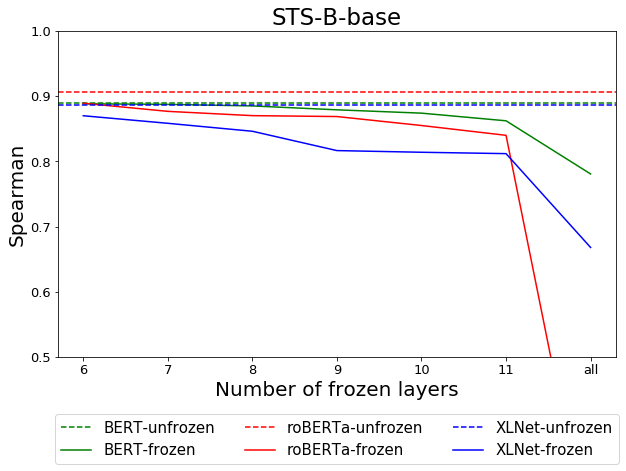

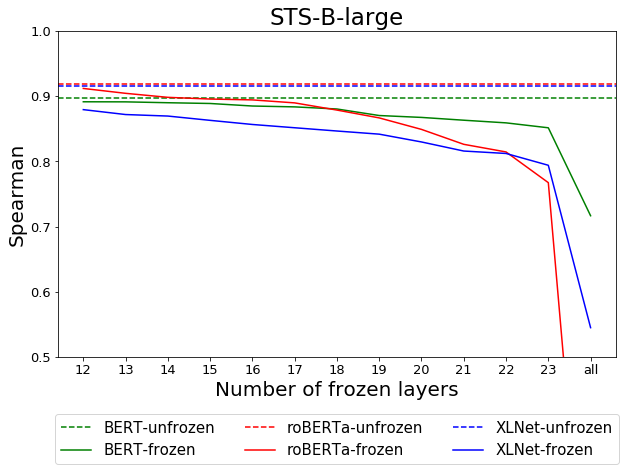

In [345]:
for task in tasks:
    task_metrics = metrics[task]
    for metric in task_metrics:
        for exp in ['base', 'large']:
            draw_graph(exp, task, metric, results[task][metric][exp])

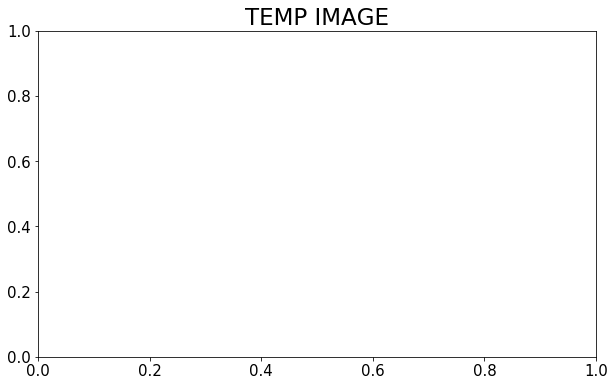

In [346]:
plt.figure(figsize=(10,6))
plt.title('TEMP IMAGE', fontsize=23)
plt.savefig(f'images/combined/temp.png', format='png', bbox_inches='tight')